#### Fine Tuning and Guidance
- With fine-tuning, we'll re-train current models on new data to adjust the type of output they provide
- With guidance, we'll take an existing model and steer the generation process at inference time for more control


In this notebook we will:
- I will create a sample loop and generate the faster samples from this using a new scheduler.
- Take a diffusion model and fine-tuning with new data:
   - By using the gradient accumulation to find out the issue with the batch of data.
- Using the guidance to add the control to existing exploring:
  - Different guidance approaches using the simple color based loss
  - with CLIP model to direct generation with a text prompt   

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [2]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)
print(device)

cuda:0


#### Load a pre-trained model
First we will use the pre-trained model from hugging face

In [7]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Generate the first images from the pipeline

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  hidden_states = F.scaled_dot_product_attention(
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1244: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  hidden_states = F.scaled_dot_product_attention(


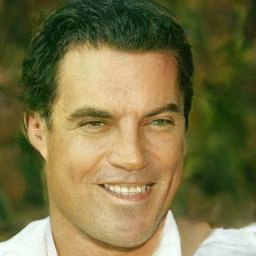

In [5]:
images = image_pipe().images
images[0]

Neat, but SLOW! So, before we get to the main subjects of today, let's have a peak at the actual sampling loop and see how we can utilize a nicer sampler to speed this up:

 #### Improved Sampling with DDIM
At each stage, the model is fed a noisy input and asked to predict the noise (and hence an estimate of what the fully denoised image could look like). Initially these predictions are not very good, which is why we split the procedure down into numerous parts. However, utilizing 1000+ steps has been determined to be unnecessary, and a flurry of recent research has studied how to get acceptable samples with as few steps as feasible.


In the Diffusers library, these sampling methods are handled by a scheduler, which must perform each update using the step() function. To generate an image, we begin with random noise ${x}$ . Then, for every timestep in the scheduler's noise schedule, we feed the noisy input to the model and give the resulting prediction to the step() function. This gives an output with a prev_sample property - previous because we're going "backwards" in time from high noise to low noise (the inverse of the forward diffusion process).

Let's see this in action! First, we load a scheduler, here a DDIMScheduler based on the work Denoising Diffusion Implicit Models which can produce good samples in many fewer steps than the original DDPM implementation:



In [3]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

We can see that this model executes 40 steps total, each jumping the equivalent of 25 steps of the original 1000-step schedule:

In [7]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

Let's generate 4 random photos and go through the sampling loop, viewing both the present and the predicted denoised version as the process progresses:


0it [00:00, ?it/s]

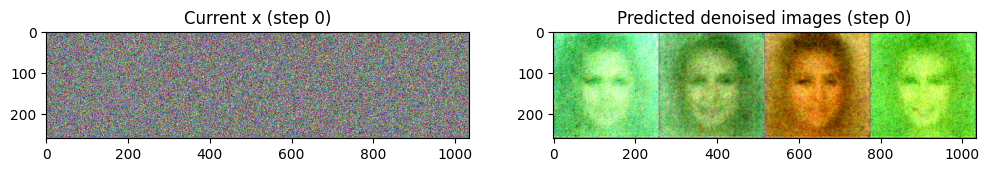

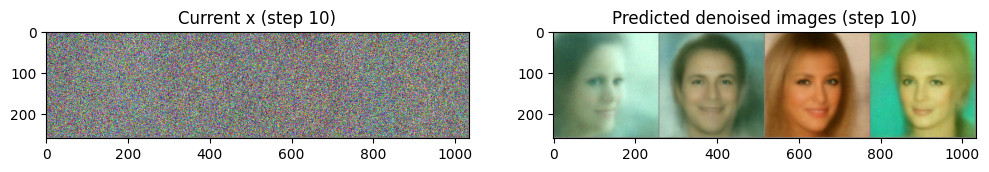

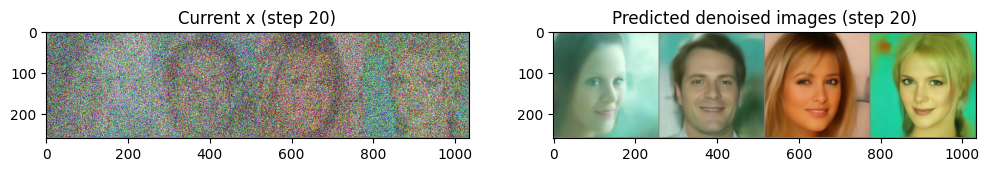

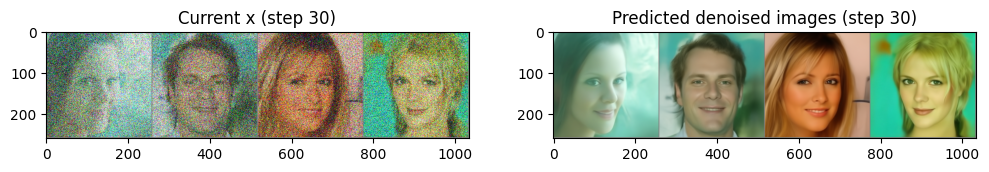

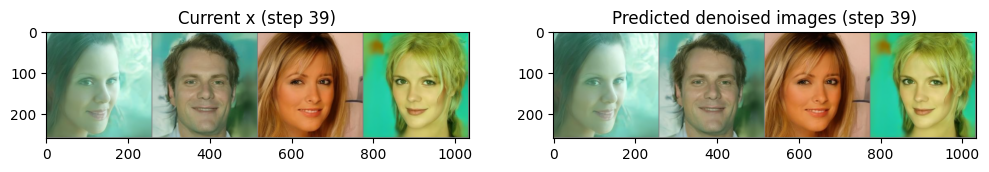

In [8]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

As you can see, the early predictions are not excellent but as the process continues on the anticipated outputs get more and more refined.

  0%|          | 0/40 [00:00<?, ?it/s]

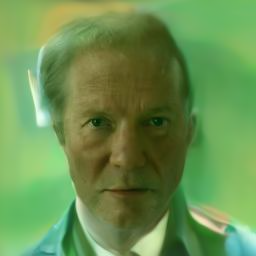

In [9]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

#### Fine Tuning
Given this pre-trained pipeline, how may we re-train the model to generate images based on new training data?

It turns out that this looks very comparable to training a model from scratch (as we saw in chapter 1) except that we begin with the existing model. Let's see this in action and talk about a few extra issues as we go.

First, the dataset: you might try this antique faces dataset or these anime faces for something closer to the original training data of this faces model, but just for fun let's instead use the same little butterfly dataset we used to train from scratch in Chapter 1. We will run the code below to download the butterfly dataset and construct a dataloader we can sample a batch of images from:



Repo card metadata block was not found. Setting CardData to empty.


Previewing batch:


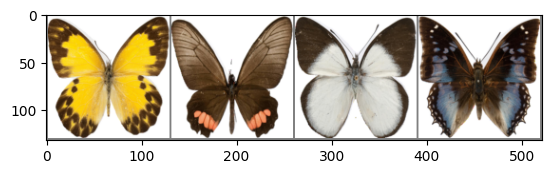

In [9]:
dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 128  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

#### First Consideration
Our batch size here (4) is relatively tiny, since we're training at huge image size (256px) using a rather large model and we'll run out of GPU RAM if we push the batch size too high. We can reduce the image size to speed things up and allow for larger batches, but these models were created and originally trained for 256px generation.

Now for the training loop. We'll update the weights of the pre-trained model by setting the optimization target to `image_pipe.unet.parameters()`. The rest is almost identical to the sample training loop from Chapter 1. 


  0%|          | 0/250 [00:00<?, ?it/s]

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  hidden_states = F.scaled_dot_product_attention(
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1244: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers

Epoch 0 average loss: 0.015102091642329469


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.016180947313085198


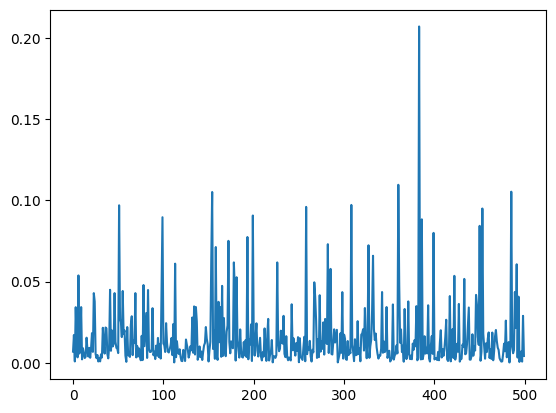

In [10]:

num_epochs = 2  # @param
lr = 1e-5  # 2param
grad_accumulation_steps = 2  # @param
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):]) / len(train_dataloader)}"
    )

# Plot the loss curve:
plt.plot(losses)

##### Second Consideration
Our loss signal is quite noisy, since we're only working with four examples at random noise levels for each step. This is not great for training. One fix is to utilize an extremely low learning rate to limit the size of the update per step. It would be much great if we could find some way to gain the same benefit we would receive from having a higher batch size without the RAM requirements soaring...

Enter gradient accumulation. If we call loss.backward() numerous times before running optimizer.step() and optimizer.zero_grad(), then PyTorch accumulates (sums) the gradients, thereby merging the signal from several batches to create a single (better) estimate which is then used to update the parameters. This results in fewer overall updates being made, precisely like we'd see if we utilized a higher batch size. This is something many frameworks can handle for you for example Accelerate makes this easy but it is wonderful to see it built from scratch as this is a helpful way for dealing with training under GPU memory limits! As you can see from the code above (after the # Gradient accumulation comment) there actually isn't much code needed.


##### Third Consideration
This still takes a lot of time, and printing out a one-line update every epoch is not enough feedback to give us a fair understanding of what is going on. We should probably:
Generate some samples sometimes to visually check the performance qualitatively as the model trains


Generating a few images with this model, we can see that these faces are already looking very strange!


0it [00:00, ?it/s]

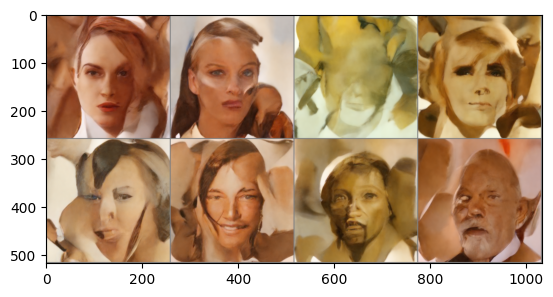

In [15]:
#Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

##### Saving and Loading Fine-Tuned Pipelines
Now that we've fine-tuned the U-Net in our diffusion model, we can save it to a local folder.


In [20]:
image_pipe.save_pretrained("my-finetuned-model")

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

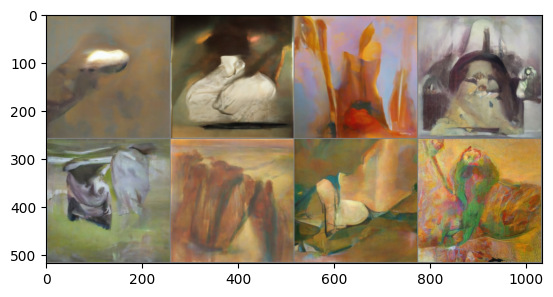

In [21]:
# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

##### Guidance
What do we do if we want some control over the samples generated? For example, assume we wanted to bias the generated images to be a given color. How would we go about that? Enter guiding, a strategy for adding more control to the sampling process.

Step one is to design our conditioning function: some measure (loss) which we'd like to reduce. Here's one for the color example, which compares the pixels of an image to a target color (by default a sort of light teal) and provides the average error:



0it [00:00, ?it/s]

0 loss: 29.242950439453125
10 loss: 11.409866333007812
20 loss: 11.052371978759766
30 loss: 11.230183601379395


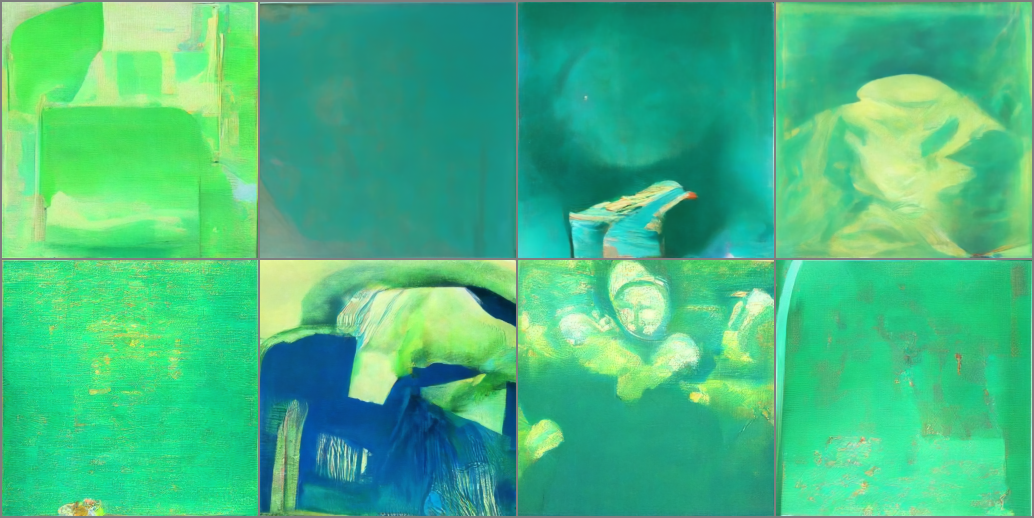

In [22]:
from utils import color_loss

# The guidance scale determines the strength of the effect
guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [9]:
# Variant 2: setting x.requires_grad before calculating the model predictions
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

OutOfMemoryError: HIP out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 7.56 GiB is allocated by PyTorch, and 155.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_HIP_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

##### Clip Guidance
Guiding towards a color offers us a small bit of power, but what if we could just input some text describing what we want?
CLIP is a model developed by OpenAI that allows us to match photos to text captions. This is tremendously powerful, since it allows us to quantify how well an image matches a question. And since the process is differentiable, we can use this as a loss function to steer our diffusion model!


The basic approach of the CLIP model is:
- Embed the text prompt to get a 512-dimensional CLIP embedding of the text 
- For every step in the diffusion process:
  - Make different combinations of the predicted denoised image (having multiple variations offers a clearer loss signal)
  - For each one, embed the image using CLIP and compare this embedding with the text embedding of the prompt (using a measure called 'Great Circle Distance Squared')
- Calculate the gradient of this loss with respect to the current noisy x and use this gradient to alter x before updating it with the scheduler.


In [5]:
#load a CLIP model and define the loss function
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(
            5
        ),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)


# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

With a loss function defined, our guided sampling loop looks similar to the previous examples, replacing color_loss() with our new clip-based loss function:

0it [00:00, ?it/s]

Step: 0 , Guidance loss: 7.506344795227051
Step: 25 , Guidance loss: 7.491272449493408


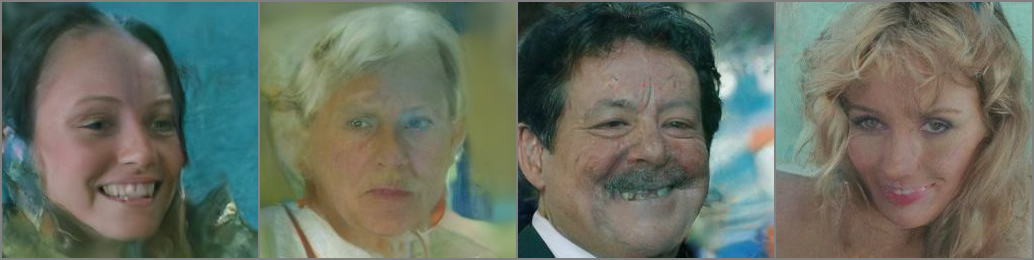

In [8]:
prompt = "Red Rose (still life), red flower painting"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)

x = torch.randn(4, 3, 256, 256).to(
    device
)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):
        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
            x.detach() + cond_grad * alpha_bar.sqrt()
    )  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

If you study the code above you'll find I'm scaling the conditioning gradient by a factor of alpha_bar.sqrt(). There is some theory showing the 'proper' way to scale these gradients, but in reality this is also something you may play with. For some sorts of guidance, you may want most of the effect concentrated in the early steps, for others (say, a style loss centered on textures) you may prefer that they only kick in towards the conclusion of the generation process. Some such schedules are shown below:


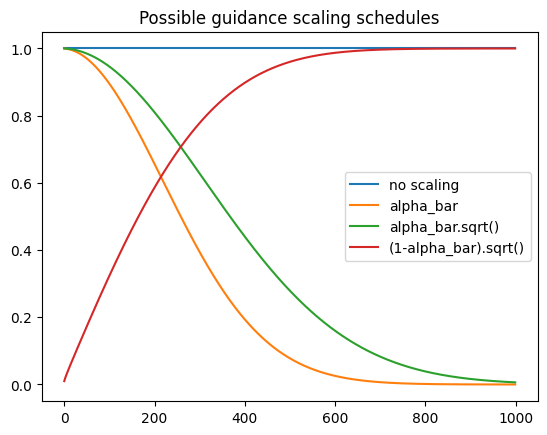

In [9]:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot(
    [(1 - a).sqrt() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()"
)
plt.legend()
plt.title("Possible guidance scaling schedules");

In [ ]:
import gradio as gr
from PIL import Image, ImageColor
from utils import color_loss


# The function that does the hard work
def generate(color, guidance_loss_scale):
    target_color = ImageColor.getcolor(color, "RGB")  # Target color as RGB
    target_color = [a / 255 for a in target_color]  # Rescale from (0, 255) to (0, 1)
    x = torch.randn(1, 3, 256, 256).to(device)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        model_input = scheduler.scale_model_input(x, t)
        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)["sample"]
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        loss = color_loss(x0, target_color) * guidance_loss_scale
        cond_grad = -torch.autograd.grad(loss, x)[0]
        x = x.detach() + cond_grad
        x = scheduler.step(noise_pred, t, x).prev_sample
    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
    im = Image.fromarray(np.array(im * 255).astype(np.uint8))
    im.save("test.jpeg")
    return im


# See the gradio docs for the types of inputs and outputs available
inputs = [
    gr.ColorPicker(label="color", value="55FFAA"),  # Add any inputs you need here
    gr.Slider(label="guidance_scale", minimum=0, maximum=30, value=3),
]
outputs = gr.Image(label="result")

# And the minimal interface
demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],  # You can provide some example inputs to get people started
    ],
)
demo.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/gradio/routes.py", line 488, in run_predict
    output = await app.get_blocks().process_api(
  File "/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/gradio/blocks.py", line 1431, in process_api
    result = await self.call_function(
  File "/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/gradio/blocks.py", line 1103, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2144, in run_sync_in_worker_thread
    return await future
  File "/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 851, in